# Description:
Given the rough location of an event, download data for this event for stations meeting a certain epicentral distance criteria.

# Setups

In [1]:
from obspy.clients.fdsn import Client
from obspy.core.event import Origin
from obspy.geodetics import gps2dist_azimuth, kilometer2degrees
from obspy.taup import TauPyModel
from obspy.io.sac.sactrace import SACTrace
from obspy import read_inventory, UTCDateTime
from obspy import read

import numpy as np
import matplotlib.pyplot as plt
plt.ioff()
%matplotlib notebook

# ***CHANGE THIS*** - things that need to be manually changed for each event

### Choose:

In [2]:
# web service client:
client = Client("IRIS")

# Earth model:
model = TauPyModel(model='iasp91')

# folder for this event:
directory = '/Users/23brianc/Documents/Internship2020/Events/Wyoming_shallow/'

# directory to download raw data:
raw_directory = directory+'raw/'

# directory to store instrument-corrected data:
corrected_directory = directory+'corrected/'

%mkdir /Users/23brianc/Documents/Internship2020/Events/Wyoming_shallow/
%mkdir /Users/23brianc/Documents/Internship2020/Events/Wyoming_shallow/raw/
%mkdir /Users/23brianc/Documents/Internship2020/Events/Wyoming_shallow/corrected/

mkdir: /Users/23brianc/Documents/Internship2020/Events/Wyoming_shallow/: File exists
mkdir: /Users/23brianc/Documents/Internship2020/Events/Wyoming_shallow/raw/: File exists
mkdir: /Users/23brianc/Documents/Internship2020/Events/Wyoming_shallow/corrected/: File exists


In [3]:
# pre-filter for removing instrument response:
prefilt = (0.05,0.1,10,20)

def detrend_and_remove_response(stream,window):
    for tr in stream:
        tr.detrend(type='constant')  # de-mean
        tr.detrend(type='linear')
        tr.remove_response(output='VEL',taper = True, taper_fraction = 0.05,pre_filt= window, water_level = 60.0)
    return stream

# Search for stations given an event

In [4]:
# search for stations certain distance away from event
station_search_lower_range=kilometer2degrees(300)  #in km
station_search_upper_range=kilometer2degrees(1100)

In [5]:
# event location: latitude and longitude

evla = 43.223 # ***CHANGE THIS***
evlo = -110.359 # ***CHANGE THIS***

# search timeframe
starttime = UTCDateTime("2016-08-26T20:47:47") # ***CHANGE THIS***
endtime = UTCDateTime("2016-08-28T20:47:47") # ***CHANGE THIS***

# station inventory
inventory = client.get_stations(level='response',channel='BH*',starttime=starttime,endtime=endtime,latitude=evla,
                               longitude=evlo, minradius=station_search_lower_range,
                                maxradius=station_search_upper_range) #network = 'XI'
inventory.write(directory+"inventory.xml",format='STATIONXML')
# inventory[x][y] gives you station y in network x

In [10]:
inventory

Inventory created at 2020-08-12T03:25:49.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.45
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2016-08-26...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (20):
			AE, BK, CC, CI, CN, IM, IU, IW, LB, LI, MB, N4, PI, PN, SC, TA, UO
			US, UU, UW
		Stations (188):
			AE.W18A (Petrified Forest, AZ, USA)
			BK.CMB (Columbia College, Columbia, CA, USA)
			BK.HATC (Hat Creek Radio Astronomy Obs., Cassel, CA, USA)
			BK.HELL (Rademacher Property, Miramonte, CA, USA)
			BK.HUMO (Hull Mountain, OR, USA)
			BK.KCC (Kaiser Creek, CA, USA)
			BK.MOD (Modoc Plateau, CA, USA)
			BK.ORV (Oroville Dam, Oroville, CA, USA)
			BK.SUTB (Sutter Buttes, CA, USA)
			BK.WDC (Whiskeytown Dam, Whiskeytown, CA, USA)
			BK.YBH (Yreka Blue Horn Mine, Yreka, CA, USA)
			CC.ASBU (Astronaut Butte)
			CC.CIHL (Cinder Hill, Newberry Volcano)
			CC.CLBH (Crater Lake Bunk House)
			CC.CPCO (Central Pumice Cone, Newberry Vol

#### plot a station map if you want to

/Users/23brianc/anaconda3/lib/python3.7/site-packages/obspy/imaging/maps.py:46: UserWarning: basemap/pyproj with proj4 version >= 5 has a bug that results in inverted map axes. Your maps may be wrong. Please use another version of proj4, or use cartopy. See https://github.com/matplotlib/basemap/issues/443
  warnings.warn(msg)


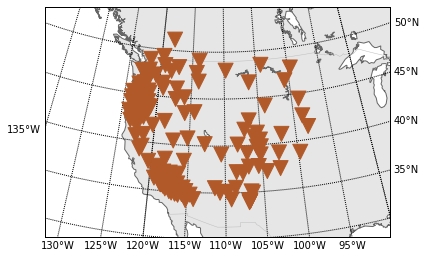

In [11]:
stn_map = inventory.plot(projection="local",show=False)

# Let the computer know the event

In [6]:
event_search_max_radius = kilometer2degrees(200) #in km

In [7]:
catalogue = client.get_events(starttime=starttime,endtime=endtime,latitude=evla,longitude=evlo,
                              maxradius=event_search_max_radius, minmagnitude=4.7,mindepth=5) # ***CHANGE THIS*** mindepth, minmag
print(catalogue)

1 Event(s) in Catalog:
2016-08-27T20:47:47.240000Z | +43.230, -110.313 | 4.8 mwr


#### Get event information

In [8]:
event_info = catalogue.events[0].origins[0]
origin_time = event_info.time
evlo = event_info.longitude
evla = event_info.latitude
evdp = event_info.depth

yr = origin_time.year
jd = origin_time.julday
hr = origin_time.hour
mins = origin_time.minute
sec = origin_time.second
msec = origin_time.microsecond

# convert event depth to km if necessary
if evdp > 1000:
    evdp = evdp / 1000

In [15]:
%store -r common_stations

origin_to_p_shallow = []

for net in inventory[:]:
    for stn in net[:]:
        stla = stn.latitude
        stlo = stn.longitude
        geo = gps2dist_azimuth(stla,stlo,evla,evlo)
        epi_dist = geo[0]/1000   #in km
        baz = geo[1]
        gcarc = kilometer2degrees(epi_dist) # convert arc length to angle
        
        arrival = model.get_travel_times(source_depth_in_km=evdp, distance_in_degree=gcarc, phase_list=['P','p'])
        P_arrival_time_at_stn = origin_time + arrival[0].time  #Only works when the UTCDateTime is first
        seconds_before_P = P_arrival_time_at_stn - 120
        seconds_after_P = P_arrival_time_at_stn + 1000
        
        for temp in common_stations:
                if temp["stnm"] == (net.code+"."+stn.code):
                    origin_to_p_shallow.append(arrival[0].time)
                    print(arrival[0].time)
                    print(temp["stnm"])
                    

133.344420665
BK.CMB
114.816911287
CC.CIHL
115.658305769
CC.CPCO
115.851323111
CC.NORM
128.933570904
CC.OBSR
123.017829372
CC.PRLK
129.584754957
CC.SWF2
116.878660995
CC.SWNB
129.459245684
CC.VALT
121.509602965
CC.WIFE
130.430849418
CI.CWC
136.022392078
CI.DAN
122.049225536
CI.FUR
135.45884264
CI.GMR
119.555872929
CI.GRA
135.148787042
CI.GSC
124.083150618
CI.MLAC
130.616549494
CI.MPM
131.177121103
CI.NEE2
135.441361222
CI.PDM
125.096351857
CI.SHO
131.186835615
CI.SLA
125.097678492
CI.TIN
128.756352488
CI.TUQ
128.102653475
CN.PNT
93.4731665355
CN.WALA
111.226739474
IM.NV31
61.6927795242
IW.MFID
62.4865603531
IW.PHWY
68.0847087857
IW.PLID
71.8580046295
IW.SMCO
79.2764716986
MB.JTMT
138.741532985
SC.Y22A
132.589981416
TA.BGNE
118.330537541
TA.G05D
127.355195178
TA.I04A
116.992274783
TA.I05D
124.64233361
TA.J04D
115.861120891
TA.J05D
121.958609793
TA.K04D
104.847821142
TA.KSCO
128.380116942
TA.L04D
127.438492615
TA.MDND
61.3460908397
TA.N23A
53.8839280897
TA.O20A
85.7153423183
TA.Q24A
92.9

In [11]:
%store origin_to_p_shallow

Stored 'origin_to_p_shallow' (list)


#### Plot a station-event map if you want to (not working now)

In [16]:
catalogue.plot(fig=stn_map);

<Figure size 432x288 with 0 Axes>

# Loop over each station in each network to request data

In [17]:
for net in inventory[:]:
    for stn in net[:]:
        stla = stn.latitude
        stlo = stn.longitude
        geo = gps2dist_azimuth(stla,stlo,evla,evlo)
        epi_dist = geo[0]/1000   #in km
        baz = geo[1]
        gcarc = kilometer2degrees(epi_dist) # convert arc length to angle
        
        arrival = model.get_travel_times(source_depth_in_km=evdp, distance_in_degree=gcarc, phase_list=['P','p'])
        P_arrival_time_at_stn = origin_time + arrival[0].time  #Only works when the UTCDateTime is first
        seconds_before_P = P_arrival_time_at_stn - 120
        seconds_after_P = P_arrival_time_at_stn + 1000
        print(P_arrival_time_at_stn)
        
        try:
            stream = client.get_waveforms(net.code,stn.code,'*','BH*',seconds_before_P,seconds_after_P,
                               attach_response=True)
        except:
            print('No Data'+' for station '+net.code+'.'+stn.code+' !!')
            continue

        number_of_traces = len(stream)
        number_of_locs = int(len(stream)/3)
        print('Found '+str(number_of_traces)+' traces for station '+net.code+'.'+stn.code)
        
        # remove mean, linear trend and instrument response
        try:
            corrected_stream = detrend_and_remove_response(stream,prefilt);
        except Exception as e:
            print('Cannot correct for station '+net.code+'.'+stn.code+' !!'+' due to ', e)
            continue
        
        # write raw data
        for tr in stream:
            loc = tr.stats.location
            chan = tr.stats.channel
            sacnm = raw_directory+'/'+net.code+'.'+stn.code+'.'+str(loc)+'.'+str(yr)+'-'+str(jd).zfill(3)+'-'+str(hr).zfill(2)+'-'+str(mins).zfill(2)+'-'+str(sec).zfill(2)+'.'+chan+'.SAC'
            sac = SACTrace.from_obspy_trace(tr)
            sac.gcarc = gcarc
            sac.baz = baz
            sac.evlo = evlo
            sac.evla = evla
            sac.stlo = stlo
            sac.stla = stla
            sac.evdp = evdp
            sac.a = P_arrival_time_at_stn
            sac.o = origin_time
            sac.write(sacnm)
        
        # write corrected data
        for tr in corrected_stream:
            loc = tr.stats.location
            chan = tr.stats.channel
            sacnm = corrected_directory+'/'+net.code+'.'+stn.code+'.'+str(loc)+'.'+str(yr)+'-'+str(jd).zfill(3)+'-'+str(hr).zfill(2)+'-'+str(mins).zfill(2)+'-'+str(sec).zfill(2)+'.'+chan+'.SAC'
            sac = SACTrace.from_obspy_trace(tr)
            sac.gcarc = gcarc
            sac.baz = baz
            sac.evlo = evlo
            sac.evla = evla
            sac.stlo = stlo
            sac.stla = stla
            sac.evdp = evdp
            sac.a = P_arrival_time_at_stn
            sac.o = origin_time
            sac.write(sacnm)

2016-08-27T20:49:45.038424Z
No Data for station AE.W18A !!
2016-08-27T20:50:00.584421Z
Found 3 traces for station BK.CMB
2016-08-27T20:49:52.274226Z
No Data for station BK.HATC !!
2016-08-27T20:50:01.999791Z
No Data for station BK.HELL !!
2016-08-27T20:50:01.285319Z
Found 3 traces for station BK.HUMO
2016-08-27T20:49:58.031206Z
No Data for station BK.KCC !!
2016-08-27T20:49:36.521186Z
No Data for station BK.MOD !!
2016-08-27T20:49:59.566741Z
No Data for station BK.ORV !!
2016-08-27T20:50:04.330601Z
No Data for station BK.SUTB !!
2016-08-27T20:50:03.955015Z
No Data for station BK.WDC !!
2016-08-27T20:50:01.061884Z
No Data for station BK.YBH !!
2016-08-27T20:49:44.243258Z
Found 3 traces for station CC.ASBU
2016-08-27T20:49:42.056911Z
Found 3 traces for station CC.CIHL
2016-08-27T20:49:52.627704Z
Found 3 traces for station CC.CLBH
2016-08-27T20:49:42.898306Z
Found 3 traces for station CC.CPCO
2016-08-27T20:49:47.614109Z
No Data for station CC.CRST !!
2016-08-27T20:49:57.186429Z
Found 3 tr

/Users/23brianc/anaconda3/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 3 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


2016-08-27T20:49:54.420343Z
Found 6 traces for station IU.ANMO
2016-08-27T20:50:03.702477Z
Found 9 traces for station IU.COR
2016-08-27T20:48:57.329676Z
Found 6 traces for station IU.RSSD
2016-08-27T20:48:48.932780Z
Found 3 traces for station IW.MFID
2016-08-27T20:48:49.726560Z
Found 3 traces for station IW.PHWY
2016-08-27T20:48:55.324709Z
Found 3 traces for station IW.PLID
2016-08-27T20:48:31.564580Z
Found 3 traces for station IW.RWWY
2016-08-27T20:48:59.098005Z
Found 3 traces for station IW.SMCO
2016-08-27T20:49:14.219278Z
No Data for station LB.BMN !!
2016-08-27T20:49:56.118405Z
No Data for station LB.DAC !!
2016-08-27T20:49:32.920524Z
No Data for station LI.LTH !!
2016-08-27T20:49:06.516472Z
Found 3 traces for station MB.JTMT
2016-08-27T20:49:38.015419Z
Found 3 traces for station N4.E28B
2016-08-27T20:49:50.380266Z
Found 3 traces for station N4.K31B
2016-08-27T20:50:04.316286Z
No Data for station PI.EP00 !!
2016-08-27T20:50:04.316311Z
No Data for station PI.EP01 !!
2016-08-27T20:50

In [21]:
type(seconds_before_P)

obspy.core.utcdatetime.UTCDateTime

### Quick preview of downloaded data

In [18]:
raw_st = read(raw_directory+'*')
corrected_st = read(corrected_directory+'*')

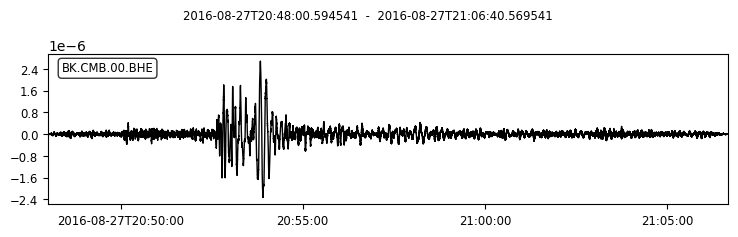

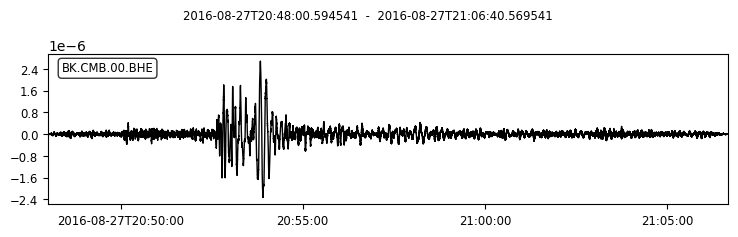

In [19]:
index = 0

raw_st[index].plot();
corrected_st[index].plot();

# Play around with individual case

In [49]:
stn = inventory[6][40]
stla = stn.latitude
stlo = stn.longitude
geo = gps2dist_azimuth(stla,stlo,evla,evlo)
epi_dist = geo[0]/1000. #in km
baz = geo[1]
gcarc = kilometer2degrees(epi_dist) # convert arc length to angle

In [50]:
model = TauPyModel(model='ak135')
arrival = model.get_travel_times(source_depth_in_km=evdp, distance_in_degree=gcarc, phase_list=['P','p'])

In [51]:
P_arrival_time_at_stn = origin_time + arrival[0].time  #Only works when the UTCDateTime is first
seconds_before_P = P_arrival_time_at_stn - 1000
seconds_after_P = P_arrival_time_at_stn + 2000

In [52]:
try:
    data = client.get_waveforms('G','WUS','*','BH*',seconds_before_P,seconds_after_P,
                               attach_response=True)
except:
    print('No Data!')

number_of_traces = len(data)
number_of_locs = int(len(data)/3)
print('Find '+str(number_of_traces)+' traces for station')  

No Data!


NameError: name 'data' is not defined

In [ ]:
data.plot();

In [ ]:
detrend_and_remove_response(data,prefilt);
data.plot();

In [ ]:
inventory[-1][61]